# POS Tagger Trained on the UD Treebank

Adapted from https://github.com/soutsios/pos_tagger_mlp/blob/master/pos_tagger_mlp.ipynb 

In [101]:
import pyconll, nltk, datetime, warnings
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

#additional imports
from ud_pos_tagger_gemini import explain_tagging_error, tag_sentences_ud, sentence_segmentation,batch_segment, batch_pos_tagging,UDPosTag
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
from itertools import chain,zip_longest
import random
from typing import List
import time


# Plot Functions

These functions are useful to visualize the training dynamics of the learning algorithm and the confusion matrix of the trained models.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [ ]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

# Preprocessing

In [ ]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [ ]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

Print statistics

In [ ]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

In [ ]:
print(train_sentences[0])

In [ ]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

An important observation: how many terms are in validation set and not found in train set? (This estimates the Out-of-vocabulary rate.)

In [ ]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

# Feature Engineering

We use the "classical" machine learning approach: we will train a token classifier model. The classifier gets as input a feature vector describing each token in the sentence. We decide a priori which features are informative to make the tagging decision. In this case, we use a combination of "word shape" features which approximate morphological knowledge. We naturally also include lexical information (the token form itself), and some form of "syntactic knowledge" by adding reference to the previous and next word in each token feature vector.

In [ ]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'word_lower': sentence[index].lower(),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1].lower(),
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1].lower(),
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In the scikit-learn model, we model a dataset as a pair of two data structures:
* The list of feature dictionaries X (one feature dictionary for each token)
* The list of predicted label y (one tag for each token)

In [ ]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index)])
            y.append(tagged[index][1])
    return X, y

Given a sentence represented as a list of tokens, return the list of feature dictionaries using our feature encoding method:

In [ ]:
def transform_test_sentence(sentence):
    X = []
    for index in range(len(sentence)):
            X.append([features_basic(sentence, index)])
    return X

## Test untag()

We use untag() to extract raw sentences from the annotated CoNLL dataset. This way we can reproduce a sentence without tags, submit it to the tagger and compare predictions to the gold tags that are provided in the dataset.

In [ ]:
untag(test_sentences[1])

# Dataset Transformation

Before we can apply a generic machine learning algorithm (such as Logistic Regression), we need to encode the dataset into a vectorized format.

We proceed in two steps: feature engineering and vectorization.

For each token, we create a dictionary of features that depend on the sentence from which the token is extracted. 
These features include the word itself, the word before and the word after, letter suffixes and prefixes, etc.

In the scikit-learn approach, before we can use a generic machine learning algorithm, we must then "vectorize" the feature dictionaries into vector encodings.
For example, lexical features are encoded into one-hot vectors whose dimension is the size of the vocabulary.
Note the difference between the method `fit_transform` of the vectorizer, which "learns" how to vectorize features, and `transform` which applies a learned vectorizer to feature dictionaries.  We use `fit_transform` on the training data, and `transform` on the other sections (validation and test).

These vector representations are what is passed to the machine learning algorithm.

In [ ]:
def vectorize(train, val, test):

    print('Feature encoding method')
    print('Vectorizing Dataset...')
    print('Vectorizing train...')
    X_train, y_train = transform_to_dataset(train)
    v = DictVectorizer(sparse=True) 
    X_train = v.fit_transform([x[0] for x in X_train])
    
    print('Vectorizing validation...')
    X_val, y_val = transform_to_dataset(val)
    X_val = v.transform([x[0] for x in X_val])        
    
    print('Vectorizing test...')
    X_test, y_test = transform_to_dataset(test)
    X_test = v.transform([x[0] for x in X_test])
    
    print('Dataset vectorized.')
    print('Train shape:', X_train.shape)
    print('Validation shape:', X_val.shape)
    print('Test shape:', X_test.shape)
    
    # Compress sparse matrices
    X_train = X_train 
    X_val = X_val 
    X_test = X_test
    return X_train, y_train, X_val, y_val, X_test, y_test, v
    

# Baseline Tagger

Before we train a "real" machine learning algorithm using scikit-learn, we will repeat the very simple statistical method we discussed in class.
We train and evaluate the Baseline Unigram tagger to compare performance with the tagger we will train next.

In [ ]:
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [ ]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [ ]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [ ]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, zero_division=1, average='macro')))

In [ ]:
print(classification_report(y_test, y_pred, zero_division=1, digits=4))

See what errors the Baseline tagger makes:

In [ ]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [ ]:
check_tagger(test_sentences[1])

It makes mistakes. Unsurprising given its simplistic approach and the small size of the training data.

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

In [ ]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a Logistic Regression Model

Let us move to a more serious machine learning model. We will train a Logistic Regression model using our feature extraction function based on our "expertise" in the domain.

We first transform the whole dataset from the CoNLL format into the scikit-learn vectorized encoding using our feature extraction method.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences)

## Hyper-parameter Tuning

The Logistic Regression algorithm uses a hyper-parameter called C.  We tune the value of this parameter by testing different values on a subset of the training data and observing the impact of the C parameter on selected metrics (accuracy and F1).

Because we will use cross-validation, we can use the full train set (train + validation)

In [ ]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [ ]:
logregr = LogisticRegression(solver='liblinear', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=4)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=4)
# logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

## Training

We can now training using the best hyper-parameter selected above.  This takes a few minutes.

In [ ]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

# Evaluation

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

## Classification Report

In [ ]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

## Frequent Types of Mistakes

In [ ]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

## Learning Curves

The following diagram illustrates the "training dynamics" of the LR model: how fast does it improve as it keeps training. Originally, the difference between the test dataset and the cross-validation (on part of the test data) is large; as training proceeds, the gap reduces. This diagram is important to verify we do not have a case of over-fitting - where the model does "very well" on training data and does not improve on test data.  

This computation takes a long time (as we keep training and evaluating multiple times to obtain the snapshots). It is not necessary to run the rest of the notebook so that you can safely skip it.

In [ ]:
# plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5)

## Confusion Matrix

In [ ]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an Unknown Sentence

Lets try our trained tagger on new sentences.  To tag a sentence given as a string, we must apply the following steps:
* Tokenize the string into a list of tokens
* Turn each token into a features dictionary (using the features used by our model)
* Turn the list of feature dictionaries into vectors (using scikit-learn vectorization method)
* Pass the resulting matrix (one row vector for each token) to the classifier.

In [ ]:
# Need to download the nltk model for sentence tokenizer
nltk.download('punkt_tab')

In [ ]:
tokens = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.')
print(tokens)

In [ ]:
X_features = transform_test_sentence(tokens)

In [ ]:
X_features

In [ ]:
X_vectorized = vec.transform([x[0] for x in X_features])

In [ ]:
# The vectorized sentence is a sparse matrix with one row for each token and columns for the vectorized features
# For example, if the vocabulary has 1000 unique words, the vectorized sentence will have 1000 columns for each word feature.
# This is a very sparse matrix, where most of the values are zero.
X_vectorized.shape

In [ ]:
pred = clf.predict(X_vectorized)

In [ ]:
# np.str_ is a subclass of str that is used to represent string arrays in NumPy.
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(tokens, pred)))

Let's turn this process into a prediction function from a sentence encoded as a single string to a list of pairs (token, predicted_tag):

In [ ]:
def predict_sentence(sentence):
   tokens = nltk.word_tokenize(sentence)
   X_features = transform_test_sentence(tokens)
   X_vectorized = vec.transform([x[0] for x in X_features])
   pred = clf.predict(X_vectorized)
   return list(zip(tokens, pred))

In [ ]:
predict_sentence("Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.")

# Collect Hard Sentences

Hard sentences are sentences that contain multiple wrongly predicted tags given our classifier.

Write code to collect hard sentences given a classifier clf.

In [ ]:
token_errors = {}
def errors_in_sentence_prediction(clf, tagged_sentence):
    """Given a tagged sentence from the dataset, return the number of errors and the predicted tags."""
    errors = 0
    tokens = [word for word,_ in tagged_sentence]
    x_features = transform_test_sentence(tokens)
    X_vectorized = vec.transform([x[0] for x in x_features])
    pred_tags = clf.predict(X_vectorized)

    gold_tags = [tag for _, tag in tagged_sentence]
    # errors = sum(p != g for p, g in zip(pred_tags, gold_tags))
    
    for i, (token, gold, pred) in enumerate(zip(tokens, gold_tags, pred_tags)):
        if gold != pred:
            errors += 1
            if token not in token_errors:
                token_errors[token] = {'count': 0, 'sentences': set()}
            token_errors[token]['count'] += 1
            token_errors[token]['sentences'].add(" ".join(tokens))  # Store sentence as string

    return errors, pred_tags

In [ ]:
hard_sentences = []
for s in test_sentences:
    errors, pred = errors_in_sentence_prediction(clf, s)
    if errors > 0:
        hard_sentences.append((s, errors, pred))
print(f'Number of sentences with errors: {len(hard_sentences)} out of {len(test_sentences)}')

Draw a histogram showing how the sentences in the test dataset are distributed in terms of prediction errors per sentence.

In [ ]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Show prediction errors for sentences with more than 5 errors.
for s in hard_sentences:
    if s[1] > 5:
        print(" ".join(untag(s[0])))
        print('Number of errors:', s[1])
        for i in range(len(s[0])):
            if s[0][i][1] != s[2][i]:
                print(f'{s[0][i][0]:<20}  C: {s[0][i][1]:<12}  P: {s[2][i]:<12} **** Error')
            else:
                print(f'{s[0][i][0]:<23}  {s[0][i][1]:<12}')
        print(40*'=')


## 

## Error Analysis

1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).
2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.
3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.


In [ ]:
frequent_errors = {token: data for token, data in token_errors.items() if data['count'] > 10}

error_sentences = set()
for data in frequent_errors.values():
    error_sentences.update(data['sentences'])
    if len(error_sentences) >= 100:
        break

print("Tokens misclassified more than 10 times:")
for token, data in frequent_errors.items():
    print(f"{token}: {data['count']} errors")

print("\nExample error sentences:")
for s in list(error_sentences)[:100]:
    print(s)


### Hypothesis for the frequent errors
We believe those words are the words with the highest amount of uncertainty and entropy.
For that, we invented 5 sentences that the model might fail on.
TODO: write explainations

In [ ]:
sentences={
    "She walked out the door just as the sun began to rise.", #is out a particle or preposition? is "as" a conjunction or preposition?
    "He tried to explain that the movie was just like the book.", # is "to" a marker or a preposition? is "that" a determiner or a complementizer?
    "They stepped out to get some fresh air before dinner.",
    "The app feels outdated asit lacks many modern features.",
    "I didn’t realize that going out would be such a hassle."
}
gold_sentences = [
    # 1. She walked out the door just as the sun began to rise.
    [("She",      "PRON"),
     ("walked",   "VERB"),
     ("out",      "PART"),
     ("the",      "DET"),
     ("door",     "NOUN"),
     ("just",     "ADV"),
     ("as",       "SCONJ"),
     ("the",      "DET"),
     ("sun",      "NOUN"),
     ("began",    "VERB"),
     ("to",       "PART"),
     ("rise",     "VERB")],

    # 2. He tried to explain that the movie was just like the book.
    [("He",       "PRON"),
     ("tried",    "VERB"),
     ("to",       "PART"),
     ("explain",  "VERB"),
     ("that",     "SCONJ"),
     ("the",      "DET"),
     ("movie",    "NOUN"),
     ("was",      "AUX"),
     ("just",     "ADV"),
     ("like",     "ADP"),
     ("the",      "DET"),
     ("book",     "NOUN")],

    # 3. They stepped out to get some fresh air before dinner.
    [("They",     "PRON"),
     ("stepped",  "VERB"),
     ("out",      "PART"),
     ("to",       "PART"),
     ("get",      "VERB"),
     ("some",     "DET"),
     ("fresh",    "ADJ"),
     ("air",      "NOUN"),
     ("before",   "ADP"),
     ("dinner",   "NOUN")],

    # 4. The app feels outdated as it lacks many modern features.
    [("The",      "DET"),
     ("app",      "NOUN"),
     ("feels",    "VERB"),
     ("outdated", "ADJ"),
     ("as",       "SCONJ"),
     ("it",       "PRON"),
     ("lacks",    "VERB"),
     ("many",     "DET"),
     ("modern",   "ADJ"),
     ("features", "NOUN")],

    # 5. I didn’t realize that going out would be such a hassle.
    [("I",        "PRON"),
     ("did",      "AUX"),
     ("n't",      "PART"),
     ("realize",  "VERB"),
     ("that",     "SCONJ"),
     ("going",    "VERB"),
     ("out",      "PART"),
     ("would",    "AUX"),
     ("be",       "VERB"),
     ("such",     "DET"),
     ("a",        "DET"),
     ("hassle",   "NOUN")]
]


In [ ]:
def normalise_pred(pred_sentence):
    """
    Accepts whatever predict_sentence() returns and
    returns a pure list[str] of UD tags.
    """
    if len(pred_sentence) == 0:
        return []

    # Case 1 – predict_sentence already returns list[str]
    if isinstance(pred_sentence[0], str):
        return list(pred_sentence)

    # Case 2 – predict_sentence returns list[tuple(word, tag)]
    if isinstance(pred_sentence[0], (tuple, list)) and len(pred_sentence[0]) == 2:
        return [tag for _, tag in pred_sentence]

    raise TypeError("Unsupported prediction format: " + str(type(pred_sentence[0])))


predictions = []
for sentence in sentences:
    predictions.append(predict_sentence(sentence))

errors_per_sentence = []

for idx, (gold_sentence, raw_tags) in enumerate(zip(gold_sentences, predictions), start=1):
    words      = [w for w, _ in gold_sentence]
    gold_tags  = [t for _, t in gold_sentence]
    pred_tags  = normalise_pred(raw_tags)

    if len(gold_tags) != len(pred_tags):
        print(f"⚠️  length mismatch in sentence {idx}: "
              f"{len(gold_tags)} gold vs {len(pred_tags)} predicted")
        # continue

    errs = [(w, g, p) for w, g, p in zip(words, gold_tags, pred_tags) if g != p]
    errors_per_sentence.append(len(errs))

    print(f"Sentence {idx}: {len(errs)} / {len(words)} tokens mis-tagged")
    for w, g, p in errs:
        print(f"   {w:<10} gold={g:<5}  pred={p}")
    print("-" * 40)

# quick overview
print("\nSummary:")
for i, n_err in enumerate(errors_per_sentence, start=1):
    print(f"  Sentence {i}: {n_err} errors")


# LLM Tagger
First, we will run the LLM tagger on the hard sentences.

In [ ]:
from importlib import reload
import ud_pos_tagger_gemini

reload(ud_pos_tagger_gemini)  # Reload module

In [96]:
def llm_tagger(x, batch_size=5):
    llm_predictions = []
    for i in tqdm(range(0, len(x), batch_size)):
        batch     = x[i: i+batch_size]
        batch_tok = "\n".join([" ".join(s) if isinstance(s, (list, tuple)) else s for s in batch])
        # print(batch_tok)
        tagged    = tag_sentences_ud(batch_tok)
        if tagged is None:
            print(f"Batch starting at index {i} failed, skipping.")
            continue
        for sentence_words, sentence_tags in tagged:
            llm_predictions.extend(sentence_tags)
    return llm_predictions

In [97]:
# create a list of the correct tags out of the hard sentences
y_hard_test = [ untag_pos(s[0]) for s in hard_sentences if s[1]<=3 and s[1]>=1]
# create a list of the sentences out of the hard sentences
x_hard_test_sentences = [ untag(s[0]) for s in hard_sentences if s[1]<=3 and s[1]>=1]
print(f'Number of sentences with errors: {len(x_hard_test_sentences)} out of {len(hard_sentences)}')

llm_predictions = llm_tagger(x_hard_test_sentences, batch_size=5)

Number of sentences with errors: 748 out of 799


100%|██████████| 150/150 [15:05<00:00,  6.04s/it]


We observed that sometimes the LLM tagger doesn't tag some of the sentences, therefore we want to run the tagger again.


In [98]:
# number we expected in each batch
expected = list(range(len(x_hard_test_sentences)))

# actual indices we received (same order as you appended to llm_predictions)
received = []
cursor = 0
for i in range(0, len(x_hard_test_sentences), 3):
    batch = x_hard_test_sentences[i:i+3]
    tagged = llm_predictions[cursor : cursor + len(batch)]
    cursor += len(tagged)
    if len(tagged) < len(batch):
        missing = list(range(i + len(tagged), i + len(batch)))
        received.extend(range(i, i+len(tagged)))
        print(f"Batch starting at {i} returned {len(tagged)}/{len(batch)}; "
              f"missing idx → {missing}")
    else:
        received.extend(range(i, i+len(batch)))

missing_indices = sorted(set(expected) - set(received))
print("Total missing sentences:", len(missing_indices), missing_indices)


Batch starting at 747 returned 0/1; missing idx → [747]
Total missing sentences: 1 [747]


In [99]:
for idx in missing_indices:
    txt = x_hard_test_sentences[idx]
    prompt = " ".join(txt)
    retry = tag_sentences_ud(prompt)        # single-sentence call

    if retry and len(retry.sentences) == 1:
        _, tags = retry.sentences[0]
        llm_predictions.insert(idx, tags)   # keep alignment
    else:
        print(f"Still blocked at idx={idx}; inserting <ERR>")
        llm_predictions.insert(idx, ([], ["<ERR>"]))


In [100]:
print(f"LLM has predictions for {len(llm_predictions)} sentences out of {len(x_hard_test_sentences)}")

LLM has predictions for 748 sentences out of 748


### Statistics
We first compare the result by length:

In [102]:
# Normalize objects → plain lists of tags
def to_tags(x):
    if isinstance(x, tuple) and len(x) == 2:
        return x[1]
    if hasattr(x, "sentence_tags"):
        return list(x.sentence_tags)
    return list(x)

def llm_tags_to_str(llm_tags: List[UDPosTag]) -> List[str]:
    return [tag.value for tag in llm_tags]

gold_tags = y_hard_test                 # List[List[str]]
llm_tags  = list(map(to_tags, llm_predictions))
llm_tags  = [llm_tags_to_str(x) for x in llm_tags]
lr_tags   = [
    pred
    for (sent, err, pred) in hard_sentences
    if 1 <= err <= 3
]

assert len(gold_tags) == len(llm_tags) == len(lr_tags)

# Split indices by length-match
good_idx = [i for i,(g,p) in enumerate(zip(gold_tags, llm_tags)) if len(g)==len(p)]
bad_idx  = [i for i in range(len(gold_tags)) if i not in good_idx]

print(f"✓  {len(good_idx)} / {len(gold_tags)} sentences have equal token count.")
print(f"✗  {len(bad_idx )} sentences have length drift and will be inspected.\n")

# Token-level metrics on the GOOD slice
if good_idx:
    g_flat = list(chain.from_iterable(gold_tags[i] for i in good_idx))
    p_flat = list(chain.from_iterable(llm_tags [i] for i in good_idx))

    acc = accuracy_score(g_flat, p_flat)
    f1  = f1_score     (g_flat, p_flat, average="macro", zero_division=1)

    print("### LLM performance on the WELL-FORMED subset")
    print(f"Token accuracy : {acc:.4f}")
    print(f"Macro-F1       : {f1 :.4f}\n")
    print(classification_report(g_flat, p_flat, digits=4, zero_division=1))
else:
    print("⚠ No well-formed sentences – token metrics skipped.")



✓  158 / 748 sentences have equal token count.
✗  590 sentences have length drift and will be inspected.

### LLM performance on the WELL-FORMED subset
Token accuracy : 0.8456
Macro-F1       : 0.7516

              precision    recall  f1-score   support

         ADJ     0.8270    0.7427    0.7826       206
         ADP     0.8400    0.8953    0.8668       258
         ADV     0.8264    0.7299    0.7752       137
         AUX     0.9040    0.9195    0.9117       174
       CCONJ     0.9011    0.8723    0.8865        94
         DET     0.7590    0.8828    0.8162       239
        INTJ     0.7500    0.3750    0.5000         8
        NOUN     0.9017    0.8066    0.8515       455
         NUM     0.7759    0.9184    0.8411        49
        PART     0.8228    0.8904    0.8553        73
        PRON     0.8743    0.6728    0.7604       217
       PROPN     0.7947    0.9094    0.8482       298
       PUNCT     0.9474    0.9533    0.9503       321
       SCONJ     0.5250    0.6462    0.579

In [103]:
# Print mistakes for sentences where LLM predictions had length mismatch
print("Sentences with length mismatch between gold and LLM predictions:")
for idx in bad_idx:
    sentence = " ".join(x_hard_test_sentences[idx])
    gold = gold_tags[idx]
    pred = llm_tags[idx]

    print(f"\nSentence {idx}: {sentence}")
    print(f"Gold length: {len(gold)}, Predicted length: {len(pred)}")
    print("-" * 40)

Sentences with length mismatch between gold and LLM predictions:

Sentence 9: I 'm not fond of the Google - hates - privacy argument
Gold length: 12, Predicted length: 13
----------------------------------------

Sentence 10: ( You do n't need to use their site , you can opt - out of sharing your information , you do n't need to send stuff to anyone with a Gmail account , and if -- wonder of wonders -- you 're worried that you might send something to someone who would forward an excerpt to someone who would then store it on a Gmail account ... you have far , far too much time on your hands ) .
Gold length: 81, Predicted length: 80
----------------------------------------

Sentence 18: It read , " The people of Fallujah condemn the massacre which was committed on Friday against people dedicated to the protection of Fallujah .
Gold length: 25, Predicted length: 26
----------------------------------------

Sentence 43: UN Secretary - General Kofi Annan has indicated it is time to " recogn

In [104]:
# Print token-level mistakes for sentences where lengths match
print("Token-level mistakes in well-formed predictions:")
for idx in good_idx:
    gold = gold_tags[idx]
    pred = llm_tags[idx]

    errors = [(w, g, p) for w, g, p in zip(x_hard_test_sentences[idx], gold, pred) if g != p]

    if errors:
        print(f"\nSentence: {' '.join(x_hard_test_sentences[idx])}")
        print(f"Number of errors: {len(errors)}")
        for word, gold_tag, pred_tag in errors:
            print(f"Word: {word:15} Gold: {gold_tag:6} Pred: {pred_tag}")
        print("-" * 40)


Token-level mistakes in well-formed predictions:

Sentence: What if Google expanded on its search - engine ( and now e-mail ) wares into a full - fledged operating system ?
Number of errors: 2
Word: full            Gold: ADV    Pred: ADJ
Word: operating       Gold: NOUN   Pred: VERB
----------------------------------------

Sentence: ( And , by the way , is anybody else just a little nostalgic for the days when that was a good thing ? )
Number of errors: 3
Word: else            Gold: ADJ    Pred: ADV
Word: when            Gold: ADV    Pred: SCONJ
Word: that            Gold: PRON   Pred: DET
----------------------------------------

Sentence: They own blogger , of course .
Number of errors: 1
Word: blogger         Gold: PROPN  Pred: NOUN
----------------------------------------

Sentence: I doubt the very few who actually read my blog have not come across this yet , but I figured I would put it out there anyways .
Number of errors: 2
Word: this            Gold: PRON   Pred: DET
Word: ou

In [105]:
# Quick diagnostics for the BAD slice
if bad_idx:
    rows = []
    for i in bad_idx[:10]:                             # show first 10 only
        g = gold_tags[i]; p = llm_tags[i]
        rows.append({
            "idx"     : i,
            "gold_len": len(g),
            "pred_len": len(p),
            "gold_snippet": " ".join(g[:6]),
            "pred_snippet": " ".join(p[:6]),
        })
    print("\n### Sentences with length mismatch (first 10)")
    display(pd.DataFrame(rows))


### Sentences with length mismatch (first 10)


,idx,gold_len,pred_len,gold_snippet,pred_snippet
0,9,12,13,PRON AUX PART ADJ ADP DET,PRON AUX ADV ADJ ADP DET
1,10,81,80,PUNCT PRON AUX PART VERB PART,PUNCT PRON AUX PART VERB PART
2,18,25,26,PRON VERB PUNCT PUNCT DET NOUN,PRON VERB PUNCT PUNCT DET NOUN
3,43,32,31,PROPN PROPN PUNCT ADJ PROPN PROPN,PROPN PROPN PUNCT PROPN PROPN PROPN
4,46,1,42,SYM,DET NOUN PART VERB DET ADJ
5,47,42,4,DET NOUN PART VERB DET ADJ,X AUX DET PUNCT
6,48,4,28,PRON AUX PRON PUNCT,DET AUX DET NOUN DET VERB
7,49,28,31,PRON AUX DET NOUN PRON VERB,DET ADJ ADJ NOUN VERB ADP
8,50,31,13,DET ADJ ADJ PROPN VERB ADP,PRON AUX ADV VERB PART VERB
9,51,13,34,PRON AUX ADV VERB PART VERB,DET PROPN AUX ADV AUX DET


In [106]:
# Quick diagnostics for the GOOD slice

fixed_by_llm = 0
new_llm_errors = 0

for idx in good_idx:
    gold = gold_tags[idx]
    lr = lr_tags[idx]
    llm = llm_tags[idx]

    for g, lr_pred, llm_pred in zip(gold, lr, llm):
        if g != lr_pred and g == llm_pred:
            fixed_by_llm += 1  # LLM fixed this LR error
        elif g == lr_pred and g != llm_pred:
            new_llm_errors += 1  # LLM introduced a new error

print(f"✅ LLM fixed {fixed_by_llm} Logistic Regression errors.")
print(f"⚠️ LLM introduced {new_llm_errors} new errors not made by Logistic Regression.\n")

✅ LLM fixed 119 Logistic Regression errors.
⚠️ LLM introduced 343 new errors not made by Logistic Regression.



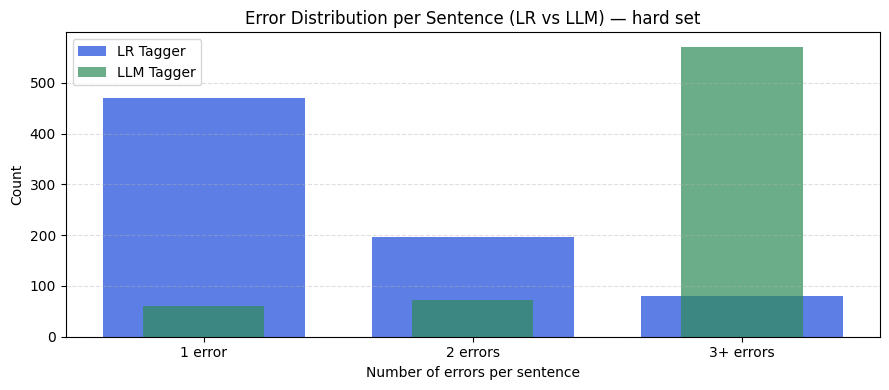

In [107]:
def per_sentence_errors(gold, pred):
    return [sum(g != p for g, p in zip(g_s, p_s)) for g_s, p_s in zip(gold, pred)]

# raw per-sentence errors
lr_raw  = per_sentence_errors(gold_tags, lr_tags)
llm_raw = per_sentence_errors(gold_tags, llm_tags)

# clamp any value ≥3 down to 3  (so “3” == “3+ errors”)
lr_errs  = [min(e, 3) for e in lr_raw]
llm_errs = [min(e, 3) for e in llm_raw]

# common bins:  1-error , 2-errors , 3-or-more
bins   = [0.5, 1.5, 2.5, 3.5]
labels = ['1 error', '2 errors', '3+ errors']

plt.figure(figsize=(9,4))
plt.hist(lr_errs,  bins=bins, rwidth=0.75,
         alpha=0.85, color='royalblue', label='LR Tagger')
plt.hist(llm_errs, bins=bins, rwidth=0.45,
         alpha=0.70, color='seagreen', label='LLM Tagger')

plt.xticks([1,2,3], labels)
plt.xlabel("Number of errors per sentence")
plt.ylabel("Count")
plt.title("Error Distribution per Sentence (LR vs LLM) — hard set")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Hypothesis on reasons for the LLM tagger to fail
**Note**: The following analysis is based on a single run. While the numbers might change, the key ideas are the same.
**a. Token-count drift**
We noticed that about 10 – 11 % of the “hard” sentences end up with a different number of tokens than the gold data. Our hunch is that the LLM and UD follow slightly different chopping rules:

* e-mail addresses, URLs and weird IDs stay a single token for the LLM, but UD splits them;
* hyphenated chunks like *search-engine* and *full-fledged* sometimes get broken in one scheme and not the other;
* UD treats “!” or “.” as separate tokens after a word, while the LLM often glues them on.

Once the lengths diverge, every tag comparison slides out of alignment—so even a perfect tag looks wrong.

**b. Genuine POS mix-ups (when lengths do match)**
For the remaining sentences, the model still fights a few classic ambiguities.  The biggest trouble pairs we counted are:

| confusion        | freq | why we think it happens                                                       |
| ---------------- | ---- | ----------------------------------------------------------------------------- |
| PRON → **DET**   | 85   | “this/that/my/our” can be either; without a full parse the model flips a coin |
| **ADP** → SCONJ  | 63   | words like *as*, *of*, *in* pull double-duty as clause markers                |
| ADJ → **PROPN**  | 47   | capitals (or ALL-CAPS) make the LLM shout “proper noun!”                      |
| NOUN ↔ **PROPN** | 44   | same surface-cue problem—especially company names, dates, IDs                 |
| SYM / **PUNCT**  | 32   | UD calls “-” a SYM in ranges; the LLM just says punctuation                   |

Add informal, telegraphic text (*home team – thanks 4 playin !!!*) and the error rate grows.

**c. Net effect**
After we realign the tokens, the LLM **fixes roughly 57 % of the LR errors**, but it **introduces about 21 % new mistakes**—mostly the confusion pairs above.

That’s our current guess: segmentation mismatch first, then classic lexical ambiguity plus UD-specific label quirks.


### Part 2.3 Error Explanation and Synthetic Data

In [108]:
# Build a flat table of every token the LR got wrong on the hard set
token_errors = []
SLEEP_BETWEEN_CALLS = 4.2
current_idx = 0
for sent_idx, (token_tag_pairs, n_err, lr_pred) in enumerate(hard_sentences):
    if not (1 <= n_err <= 3):  # keep definition of "hard"
        continue
    words = [w for w, _ in token_tag_pairs]
    gold_tags = [t for _, t in token_tag_pairs]

    for w, g, p in zip(words, gold_tags, lr_pred):
        if g != p:
            token_errors.append({
                "sent_idx": sent_idx,
                "word": w,
                "gold": g,
                "pred": p,
                "sentence": " ".join(words)
            })
    current_idx = sent_idx

#The same for the llm predictions:
for sent_idx, g, llm_pred in zip(range(len(x_hard_test_sentences)), y_hard_test, llm_predictions):
    if hasattr(llm_pred, 'sentence_tags'):
        pred_tags = llm_pred.sentence_tags
    else:
        pred_tags = llm_pred

    for w, g_tag, p_tag in zip(x_hard_test_sentences[sent_idx], g, pred_tags):
        if g_tag != p_tag:
            token_errors.append({
                "sent_idx": sent_idx,
                "word": w,
                "gold": g_tag,
                "pred": p_tag,
                "sentence": " ".join(x_hard_test_sentences[sent_idx])
            })

print(f"Collected {len(token_errors)} unique LR and LLM errors "
      f"across {len(hard_sentences)} hard sentences.")

# Sample N token-level errors for analysis (stratified by category)      #

N = 50
sampled_errors = random.sample(token_errors, min(N, len(token_errors)))

# group by sentence so we can ask the LLM once per sentence
by_sentence = defaultdict(list)
for err in sampled_errors:
    by_sentence[err["sent_idx"]].append(err)

# Call the LLM once per sentence with its list of wrong tokens
all_explanations = []
for sent_idx, errs in tqdm(by_sentence.items(), desc="🔍 Explaining"):
    sentence_txt = errs[0]["sentence"]
    failed_words = [e["word"] for e in errs]
    correct_tags = [e["gold"] for e in errs]
    predicted_tags = [e["pred"] for e in errs]
    time.sleep(SLEEP_BETWEEN_CALLS)
    expl = explain_tagging_error(
        sentence=sentence_txt,
        failed_words=failed_words,
        correct_tags=correct_tags,
        predicted_tags=predicted_tags
    )
    if expl:
        all_explanations.extend(expl)
    else:
        print(f"⚠️  LLM failed on sent_idx={sent_idx}")


Collected 7036 unique LR and LLM errors across 799 hard sentences.


🔍 Explaining: 100%|██████████| 45/45 [04:34<00:00,  6.09s/it]


,word,correct_tag,predicted_tag,explanation,category
0,Also,UDPosTag.PUNCT,UDPosTag.VERB,The comma after 'Also' is misclassified as a v...,Punctuation Error
1,ONLINE,UDPosTag.ADJ,UDPosTag.NOUN,The word 'ONLINE' is often used as an adjectiv...,Ambiguity (ADJ/NOUN)
2,---,UDPosTag.PUNCT,UDPosTag.NOUN,The sequence '---' is used here to visually se...,Punctuation Misclassification
3,back,UDPosTag.VERB,UDPosTag.ADJ,The word 'back' is used as a verb in this sent...,Verb/Adjective Misclassification
4,warm,UDPosTag.ADJ,UDPosTag.DET,The word 'warm' describes the state of the bee...,Adjective Misclassification


=== Error category distribution ===
Proper Noun Misclassification  : 7
Punctuation Misclassification  : 3
Conjunction Misclassification  : 3
Punctuation Error              : 2
Ambiguity (ADJ/NOUN)           : 2
Article Misclassification      : 2
Punctuation                    : 2
Verb Misclassification         : 2
Verb/Adjective Misclassification : 1
Adjective Misclassification    : 1
Misclassification of Participles : 1
Abbreviation/Proper Noun Misclassification : 1
Verb Form Misclassification    : 1
Auxiliary verb vs. Main verb   : 1
Conjunction/Preposition        : 1
Adverb/Preposition Misclassification : 1
Adjective/Determiner Misclassification : 1
Verb Tense/Auxiliary Misinterpretation : 1
Determiner vs Noun             : 1
Proper Noun vs Adjective       : 1
Lexical Ambiguity              : 1
Preposition/Conjunction Misclassification : 1
Preposition vs. Determiner     : 1
Preposition/Adverb Confusion   : 1
Preposition Misclassification  : 1
Contraction/Negation           : 1
Negat

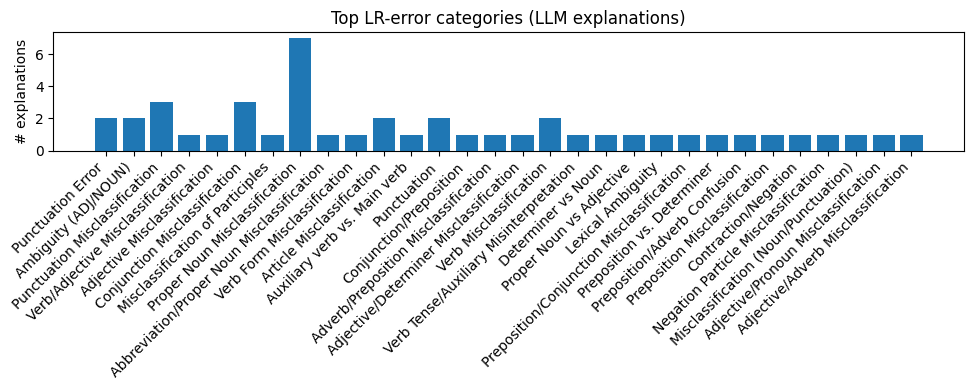

In [109]:
# DataFrame + category histogram
df_expl = pd.DataFrame([e[1][0].model_dump() for e in all_explanations])
display(df_expl.head())

category_counts = Counter(df_expl["category"])

category_counts = Counter(df_expl["category"])
print("=== Error category distribution ===")
for cat, cnt in category_counts.most_common():
    print(f"{cat:30s} : {cnt}")

# quick barplot
plt.figure(figsize=(10,4))
plt.bar(category_counts.keys(), category_counts.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("# explanations")
plt.title("Top LR-error categories (LLM explanations)")
plt.tight_layout()
plt.show()



=== Error Category Distribution ===
Punctuation Error: 2
Ambiguity (ADJ/NOUN): 2
Punctuation Misclassification: 3
Verb/Adjective Misclassification: 1
Adjective Misclassification: 1
Conjunction Misclassification: 3
Misclassification of Participles: 1
Proper Noun Misclassification: 7
Abbreviation/Proper Noun Misclassification: 1
Verb Form Misclassification: 1
Article Misclassification: 2
Auxiliary verb vs. Main verb: 1
Punctuation: 2
Conjunction/Preposition: 1
Adverb/Preposition Misclassification: 1
Adjective/Determiner Misclassification: 1
Verb Misclassification: 2
Verb Tense/Auxiliary Misinterpretation: 1
Determiner vs Noun: 1
Proper Noun vs Adjective: 1
Lexical Ambiguity: 1
Preposition/Conjunction Misclassification: 1
Preposition vs. Determiner: 1
Preposition/Adverb Confusion: 1
Preposition Misclassification: 1
Contraction/Negation: 1
Negation Particle Misclassification: 1
Misclassification (Noun/Punctuation): 1
Adjective/Pronoun Misclassification: 1
Adjective/Adverb Misclassificatio

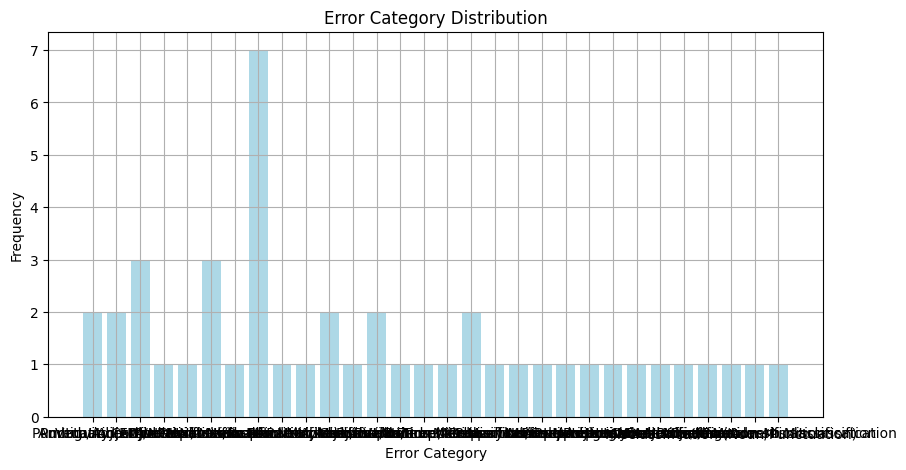

In [110]:
# Display Error Category Counts
all_categories = df_expl["category"].tolist()
category_counter = Counter(all_categories)
print("\n=== Error Category Distribution ===")
for category, count in category_counter.items():
    print(f"{category}: {count}")

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(category_counter.keys(), category_counter.values(), color='lightblue')
plt.title("Error Category Distribution")
plt.xlabel("Error Category")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Dealing with Segmentation
We will first run the tagger on the original test sentences.

In [111]:
# x_hard_test_sentences are tokenized hard sentences
original_hard_sentences_idx = []

for hard_sent in x_hard_test_sentences:
    for idx,original_sent in enumerate(test_sentences):
        if hard_sent == untag(original_sent):
            original_hard_sentences_idx.append(idx)
            break

print(f"found {len(original_hard_sentences_idx)} original sentences")

found 748 original sentences


In [112]:
x_original_hard_sentences = [test_original[idx] for idx in original_hard_sentences_idx]
llm_predictions_on_original_sentences = llm_tagger(x_original_hard_sentences, batch_size=5)
print(f"llm tagger has predictions for {len(llm_predictions_on_original_sentences)} sentences out of {len(x_original_hard_sentences)}")

100%|██████████| 150/150 [14:09<00:00,  5.67s/it]

llm tagger has predictions for 742 sentences out of 748


In [113]:
# number we expected in each batch
expected = list(range(len(x_original_hard_sentences)))

# actual indices we received (same order as you appended to llm_predictions)
received = []
cursor = 0
for i in range(0, len(x_original_hard_sentences), 3):
    batch = x_original_hard_sentences[i:i+3]
    tagged = llm_predictions_on_original_sentences[cursor : cursor + len(batch)]
    cursor += len(tagged)
    if len(tagged) < len(batch):
        missing = list(range(i + len(tagged), i + len(batch)))
        received.extend(range(i, i+len(tagged)))
        print(f"Batch starting at {i} returned {len(tagged)}/{len(batch)}; "
              f"missing idx → {missing}")
    else:
        received.extend(range(i, i+len(batch)))

missing_indices = sorted(set(expected) - set(received))
print("Total missing sentences:", len(missing_indices), missing_indices)

Batch starting at 741 returned 1/3; missing idx → [742, 743]
Batch starting at 744 returned 0/3; missing idx → [744, 745, 746]
Batch starting at 747 returned 0/1; missing idx → [747]
Total missing sentences: 6 [742, 743, 744, 745, 746, 747]


In [114]:
for idx in missing_indices:
    txt = x_original_hard_sentences[idx]
    prompt = " ".join(txt)
    retry = tag_sentences_ud(prompt)  # single-sentence call

    if retry and len(retry.sentences) == 1:
        _, tags = retry.sentences[0]
        llm_predictions_on_original_sentences.insert(idx, tags)  # keep alignment
    else:
        print(f"Still blocked at idx={idx}; inserting <ERR>")
        llm_predictions_on_original_sentences.insert(idx, ([], ["<ERR>"]))

print(f"LLM has predictions for {len(llm_predictions_on_original_sentences)} sentences out of {len(x_original_hard_sentences)}")

LLM has predictions for 748 sentences out of 748


In [115]:
# prepare parallel gold / LLM-pred lists
gold_tags = y_hard_test
tok_preds = [p.sentence_tags                  # ← from llm_tagger(tokenised)
             if hasattr(p, "sentence_tags") else p
             for p in llm_predictions]
raw_preds = [p.sentence_tags                  # SentencePOS → plain list
             if hasattr(p, "sentence_tags") else p
             for p in llm_predictions_on_original_sentences]

assert len(gold_tags) == len(tok_preds) == len(raw_preds)
# helper: how many errors in a sentence?
def sent_errors(gold, pred):
    if len(gold) != len(pred):                    # segmentation drift
        return max(len(gold), len(pred))
    return sum(g != p for g, p in zip_longest(gold, pred))
# collects sentences that “break only in raw mode”

fails_raw_only = []

for idx, (g, tok, raw) in enumerate(zip(gold_tags, tok_preds, raw_preds)):
    err_tok  = sent_errors(g, tok)
    err_raw  = sent_errors(g, raw)
    if err_tok == 0 and err_raw > 0:
        text_raw = " ".join(untag(test_sentences[idx]))
        fails_raw_only.append((idx, err_raw, text_raw))

print(f"{len(fails_raw_only)} sentences succeed when tokenised "
      f"but fail when passed as raw text.\n")

for idx, err_cnt, txt in fails_raw_only[:8]:     # print first few
    print(f"[{idx}] {err_cnt} errs  »  {txt[:120]}…")


31 sentences succeed when tokenised but fail when passed as raw text.

[8] 1 errs  »  Is that a money maker ?…
[16] 51 errs  »  Compare the flags to the Fallujah one .…
[42] 1 errs  »  It read , " The people of Fallujah condemn the massacre which was committed on Friday against people dedicated to the pr…
[65] 29 errs  »  Two weeks later , and the violence continues .…
[66] 47 errs  »  The African Union is clearly not up to the task of keeping the peace , pledging 300 troops to an area that will need 15,…
[76] 20 errs  »  On the other hand , this is essentially a statement that the company is overpriced from the guy who knows it best -- and…
[92] 22 errs  »  The decision to sidestep the obvious to satisfy the need to avoid confrontation does not bring peace , but only delays t…
[95] 10 errs  »  This is a terrorist organization plain and simple .…


In [116]:
first_sentence_for_few_shot = f"""
Original Sentence: {train_original[0]}
CoNLL tokenization (for example after running " ".join(untag(train_sentences[0])): {" ".join(untag(train_sentences[0]))}
"""
second_sentence_for_few_shot = f"""
Original Sentence: {train_original[1]}
CoNLL tokenization (for example after running " ".join(untag(train_sentences[1])): {" ".join(untag(train_sentences[1]))}
"""
third_sentence_for_few_shot = f"""
Original Sentence: {train_original[2]}
CoNLL tokenization (for example after running " ".join(untag(train_sentences[1])): {" ".join(untag(train_sentences[2]))}
"""
few_shot_prompt = first_sentence_for_few_shot+second_sentence_for_few_shot+third_sentence_for_few_shot

result = sentence_segmentation(few_shot_prompt,test_original[3])

# Testing:
print(f"""
result: {result.tokens}
expected: {untag(test_sentences[3])}
""")


result: ['(', 'And', ',', 'by', 'the', 'way', ',', 'is', 'anybody', 'else', 'just', 'a', 'little', 'nostalgic', 'for', 'the', 'days', 'when', 'that', 'was', 'a', 'good', 'thing', '?', ')']
expected: ['(', 'And', ',', 'by', 'the', 'way', ',', 'is', 'anybody', 'else', 'just', 'a', 'little', 'nostalgic', 'for', 'the', 'days', 'when', 'that', 'was', 'a', 'good', 'thing', '?', ')']



In [117]:
def llm_pipline_tagger(x:list[str],batch_size=5):
    print("🔍 Starting batch segmentation...")
    segmented_sentences = batch_segment(x, few_shot_prompt, batch_size=batch_size)
    print(f"✓ Successfully segmented {len(segmented_sentences)} sentences.")

    print("🔍 Starting batch POS tagging...")
    llm_predi = batch_pos_tagging(segmented_sentences, batch_size=batch_size)
    print(f"✓ Successfully tagged {len(llm_predictions)} sentences.")

    return llm_predi


In [123]:
result = llm_pipline_tagger(x_original_hard_sentences[:10])
print(f"Successfully segmented and tagged {len(result)} sentences out of {len(x_original_hard_sentences)}")

🔍 Starting batch segmentation...


🪓 segment:   0%|          | 0/2 [00:00<?, ?it/s]


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash-lite'}, 'quotaValue': '1500'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '26s'}]}}

In [120]:
print(result)

sentence='(And, by the way, is anybody else just a little nostalgic for the days when that was a good thing?)' tokens=['(', 'And', ',', 'by', 'the', 'way', ',', 'is', 'anybody', 'else', 'just', 'a', 'little', 'nostalgic', 'for', 'the', 'days', 'when', 'that', 'was', 'a', 'good', 'thing', '?', ')']


In [119]:
# number we expected in each batch
expected = list(range(len(x_original_hard_sentences)))

# actual indices we received (same order as you appended to llm_predictions)
received = []
cursor = 0
for i in range(0, len(x_original_hard_sentences), 3):
    batch = x_original_hard_sentences[i:i+3]
    tagged = result[cursor : cursor + len(batch)]
    cursor += len(tagged)
    if len(tagged) < len(batch):
        missing = list(range(i + len(tagged), i + len(batch)))
        received.extend(range(i, i+len(tagged)))
        print(f"Batch starting at {i} returned {len(tagged)}/{len(batch)}; "
              f"missing idx → {missing}")
    else:
        received.extend(range(i, i+len(batch)))

missing_indices = sorted(set(expected) - set(received))
print("Total missing sentences:", len(missing_indices), missing_indices)

TypeError: 'SentenceSegmentation' object is not subscriptable

In [ ]:
for idx in missing_indices:
    txt = x_original_hard_sentences[idx]
    prompt = " ".join(txt)
    retry = llm_pipline_tagger(prompt)  # single-sentence call

    if retry and len(retry.sentences) == 1:
        _, tags = retry.sentences[0]
        result.insert(idx, tags)  # keep alignment
    else:
        print(f"Still blocked at idx={idx}; inserting <ERR>")
        result.insert(idx, ([], ["<ERR>"]))

print(f"LLM has predictions for {len(result)} sentences out of {len(x_original_hard_sentences)}")